In [1]:
# Making imports convenient
import sys
import os
PATH=os.getcwd().split('/notebooks')[0]
sys.path.insert(1, PATH)

import torch
from datasets import load_dataset, concatenate_datasets
import transformers

from transformers import AutoTokenizer, DataCollatorWithPadding,AutoModelForSequenceClassification,TrainingArguments,Trainer

from src.utils.myutils import *
from tqdm import tqdm
import logging
import warnings
import pandas as pd

logging.disable(logging.ERROR)
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning) 

CS_DATA_PATH = PATH + '/data/CS/processed/'
CONFIG_PATH = PATH + '/src/utils/config.yaml'

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model_name = 'fav-kky/FERNET-C5'
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False,padding=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

BATCH_SIZE = 32

training_args = TrainingArguments(
            output_dir = './',
            num_train_epochs=3,
            save_total_limit=2,
            disable_tqdm=False,
            per_device_train_batch_size=32,  
            warmup_steps=0,
            weight_decay=0.1,
            logging_dir='./',
            learning_rate=2e-5)

In [2]:
unbalanced_path = '/home/horyctom/bias-detection-thesis/src/models/trained/mb_unbalanced.pth'
balanced_path = '/home/horyctom/bias-detection-thesis/src/models/trained/mb_balanced.pth'

## Data

In [3]:
basil = load_dataset('csv',data_files = CS_DATA_PATH + 'BASIL/basil.csv')['train']
nfnj = load_dataset('csv',data_files = CS_DATA_PATH + 'NFNJ/nfnj.csv')['train']
ua_crisis = load_dataset('csv',data_files = CS_DATA_PATH + 'UA-crisis/ua-crisis.csv')['train']

mb = concatenate_datasets([basil,nfnj,ua_crisis])

In [4]:
mb_unbalanced = mb

In [5]:
mb_balanced = resample(mb)

## Training unbalanced

In [21]:
tokenized = preprocess_data(mb_unbalanced,tokenizer,'sentence')
tokenized = tokenized.train_test_split(0.2)

In [16]:
pretraining_args = TrainingArguments(
    num_train_epochs=7,
    per_device_train_batch_size=BATCH_SIZE,  
    per_device_eval_batch_size=BATCH_SIZE,
    eval_steps=20,
    logging_steps=20,
    save_steps=400,
    disable_tqdm = False,
    warmup_steps=0,
    save_total_limit=1,
    evaluation_strategy="steps",
    weight_decay=0.1,
    output_dir = './',
    learning_rate=2e-5)

In [25]:
model = AutoModelForSequenceClassification.from_pretrained(model_name,num_labels=2);
model.to(device)
trainer = Trainer(model,pretraining_args,train_dataset=tokenized['train'],data_collator=data_collator,
                  tokenizer=tokenizer,eval_dataset=tokenized['test'],compute_metrics=compute_metrics_eval)
trainer.train()

Step,Training Loss,Validation Loss,F1
50,0.388400,0.331316,0.007782
100,0.311500,0.351869,0.117216
150,0.348400,0.312136,0.141343
200,0.316400,0.311505,0.162544
250,0.332100,0.303918,0.067669
300,0.309800,0.298731,0.310976
350,0.287900,0.300042,0.373259
400,0.269100,0.302935,0.436019
450,0.242100,0.289016,0.364672
500,0.239000,0.288811,0.448878


TrainOutput(global_step=1360, training_loss=0.182099994381561, metrics={'train_runtime': 350.4925, 'train_samples_per_second': 124.154, 'train_steps_per_second': 3.88, 'total_flos': 1465108731221940.0, 'train_loss': 0.182099994381561, 'epoch': 5.0})

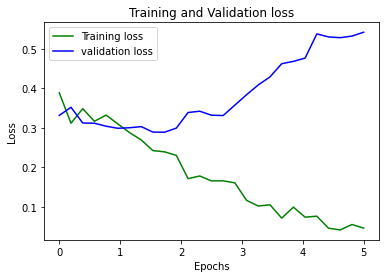

In [26]:
losses = pd.read_csv('loss.unbalanced',sep='\t')
plot_losses(losses)

In [27]:
pretraining_args = TrainingArguments(
    num_train_epochs=2,
    per_device_train_batch_size=32,  
    logging_steps=20,
    save_steps=400,
    disable_tqdm = False,
    warmup_steps=0,
    save_total_limit=1,
    weight_decay=0.1,
    output_dir = './',
    learning_rate=2e-5)

In [28]:
tokenized = preprocess_data(mb_unbalanced,tokenizer,'sentence')

In [29]:
model = AutoModelForSequenceClassification.from_pretrained(model_name,num_labels=2);
model.to(device)
trainer = Trainer(model,pretraining_args,train_dataset=tokenized,data_collator=data_collator,
                  tokenizer=tokenizer,eval_dataset=tokenized,compute_metrics=compute_metrics_eval)
trainer.train()

torch.save(model.state_dict(),balanced_path)

Step,Training Loss
20,0.365400
40,0.372100
60,0.356000
80,0.366000
100,0.366100
120,0.350600
140,0.379500
160,0.348200
180,0.278600
200,0.337600


In [30]:
torch.save(model.state_dict(),unbalanced_path)

# Balanced Training 

In [17]:
tokenized = preprocess_data(mb_balanced,tokenizer,'sentence')
tokenized = tokenized.train_test_split(0.2)

In [18]:
model = AutoModelForSequenceClassification.from_pretrained(model_name,num_labels=2);
model.to(device)
trainer = Trainer(model,pretraining_args,train_dataset=tokenized['train'],data_collator=data_collator,
                  tokenizer=tokenizer,eval_dataset=tokenized['test'],compute_metrics=compute_metrics_eval)
trainer.train()

Step,Training Loss,Validation Loss,F1
20,0.701600,0.689181,0.567376
40,0.681600,0.677622,0.464548
60,0.668600,0.687150,0.645057
80,0.638700,0.671067,0.453333
100,0.643200,0.646504,0.661972
120,0.637500,0.683039,0.420749
140,0.580400,0.635297,0.578475
160,0.544300,0.629436,0.666667
180,0.564000,0.621067,0.639676
200,0.528200,0.606396,0.629067


TrainOutput(global_step=448, training_loss=0.42932591321212904, metrics={'train_runtime': 118.6533, 'train_samples_per_second': 120.587, 'train_steps_per_second': 3.776, 'total_flos': 501078560492160.0, 'train_loss': 0.42932591321212904, 'epoch': 7.0})

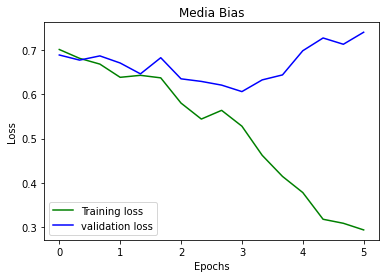

In [20]:
plot_losses( pd.read_csv('./logs/mb2.loss',sep='\t'),epochs=5.0,name="Media Bias")

## Train on all

In [18]:
pretraining_args = TrainingArguments(
    num_train_epochs=3,
    per_device_train_batch_size=32,  
    logging_steps=20,
    save_steps=400,
    disable_tqdm = False,
    warmup_steps=0,
    save_total_limit=1,
    weight_decay=0.1,
    output_dir = './',
    learning_rate=2e-5)

In [19]:
tokenized = preprocess_data(mb_balanced,tokenizer,'sentence')

In [20]:
model = AutoModelForSequenceClassification.from_pretrained(model_name,num_labels=2);
model.to(device)
trainer = Trainer(model,pretraining_args,train_dataset=tokenized,data_collator=data_collator,
                  tokenizer=tokenizer,eval_dataset=tokenized,compute_metrics=compute_metrics_eval)
trainer.train()

torch.save(model.state_dict(),balanced_path)

Step,Training Loss
20,0.689300
40,0.656000
60,0.655500
80,0.629100
100,0.551100
120,0.562700
140,0.564400
160,0.519100
180,0.450600
200,0.448700
